<div align="center" style="border-radius: 10px; overflow: hidden; box-shadow: 0px 0px 10px rgba(0, 0, 0, 0.1);">
  <img src="https://storage.googleapis.com/kaggle-datasets-images/8782/12270/c3af536d14e386a2bfd356d1cd84b67e/dataset-cover.jpg?t=2018-01-06-14-10-54" alt="Flower Dataset" style="border-radius: 10px;">
</div>

<div align="center" style="background-color: #f5f5f5; padding: 20px; border-radius: 10px; box-shadow: 0px 0px 10px rgba(0, 0, 0, 0.1); color: #555;">

# Flowers Recognition
### A Convolutional Neural Network with 6.5M Learnable Petals
###### ITHS AI22 Deep Learning Course | December 2023
</div>

[This dataset](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
) contains 4242 images of flowers.

### Content

The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion.
For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

### Acknowledgements

The data collection is based on scraped data from flickr, google images, and yandex images.

https://www.kaggle.com/datasets/alxmamaev/flowers-recognition

In [1]:
from tensorflow.data import Dataset

2023-12-12 21:50:06.805080: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Resources & Documentation

[api_docs/tf/keras/utils/image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)

[tensorflow.org/tutorials/images/classification](https://www.tensorflow.org/tutorials/images/classification)


# Creating a dataset (Train|Val|Test Split)

We first start out by creating our dataset. For this I use the image_dataset_from_directory API.<br>
By making it a function, we can call it with different parameters later on.

We use the take & skip methods to move a bunch of validation data into test data.

This results in:

xx% training:
- xx% training is used to adjust the weights in the network.
- xx% in-training validation used only to check metrics of the model after each epoch.

xx% testing (never seen by the training process at all)

**#TODO update values when satisfied with inference**

I've decided to stick to just a few batches of of test data (maybe just one?), as my intention is to test the model on new data. (e.g., flower images from search engines etc.)

In [26]:
from tensorflow.keras.preprocessing import image_dataset_from_directory as get_data
from tensorflow import one_hot

def create_dataset(data_dir='Data/flowers', batch_size=128, img_size=(224,224), val_size=0.2, shuffle=True, random_seed=42):

    print(f"Creating dataset with batch size: {batch_size}")

    train_ds = get_data(
      data_dir,
      validation_split=val_size,
      subset="training",
      seed=random_seed,
      image_size=img_size,
      batch_size=batch_size,
      shuffle=shuffle)

    val_ds = get_data(
      data_dir,
      validation_split=val_size,
      subset="validation",
      seed=random_seed,
      image_size=img_size,
      batch_size=batch_size,
      shuffle=shuffle)

    # Extracting test data from validation split
    val_batches = len(val_ds)
    test_ds = val_ds.take((val_batches) // 6)
    new_val_ds = val_ds.skip((val_batches) // 6)

    percent_test = len(test_ds) / (len(val_ds) + len(test_ds)) * 100

    print(f"Moving {len(val_ds) - len(new_val_ds)} batch(es) from validation to test.")
    print(f"Using {len(test_ds)*batch_size} files ({percent_test:.2f}%) for test.\n")

    class_names = train_ds.class_names

    # One-hot encoding labels
    try:
        num_classes = len(train_ds.class_names)
        train_ds = train_ds.map(lambda x, y: (x, one_hot(y, depth=num_classes)))
        new_val_ds = new_val_ds.map(lambda x, y: (x, one_hot(y, depth=num_classes)))
        test_ds = test_ds.map(lambda x, y: (x, one_hot(y, depth=num_classes)))
        print('Labels successfully encoded.')
    except Exception as e:
        print(f'Error during one-hot encoding: {e}')
        
    return train_ds, new_val_ds, test_ds, class_names


In [27]:
train_ds, val_ds, test_ds, class_names = create_dataset(shuffle=True, random_seed=3)

Creating dataset with batch size: 128
Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.
Moving 1 batch(es) from validation to test.
Using 128 files (12.50%) for test.

Labels successfully encoded.


When using `image_dataset_from_directory`, labes are automatically integer encoded in the dataset. One integer represent one type of flower.<br>
For multi-class classification tasks (like identifying different types of flowers), it is common to employ a technique one-hot encoding.<sup>[citation needed]</sup>


In [29]:
for images, labels in train_ds.take(1):
    print(labels.shape)

(128, 5)


# Preprocessing (Normalization)

In [30]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 224, 224, 3)
(128, 5)


The image_batch is a tensor of the shape (128, 224, 224, 3). This is a batch of 128 images of shape 224x224x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (128,), these are corresponding labels to the 128 images.

For one image:

In [31]:
for image_batch in train_ds:
  print(image_batch[0][0].shape)
  break

(224, 224, 3)


And a snippet of a tensor channel:

```
tf.Tensor(
[[[ 65.03571   132.03572   184.03572  ]
  [ 66.        133.        185.       ]
  [ 66.17857   133.17857   185.35715  ]
  ...
```

In [33]:
import numpy as np
print(type(train_ds))

for images, labels in train_ds.take(1):
    print(np.min(images), np.max(images))

<class 'tensorflow.python.data.ops.map_op._MapDataset'>
0.0 255.0


Default RGB values range between 0 and 255. We want to normalize these values.

In [34]:
def normalize_image(img, label):
    return img / 255, label

train_ds_normalized = train_ds.map(normalize_image)
val_ds_normalized = val_ds.map(normalize_image)
test_ds_normalized = test_ds.map(normalize_image)

for images, labels in train_ds_normalized.take(1):
    print(np.min(images), np.max(images))

0.0 1.0


When we use the map function on a tf.data.Dataset (or PrefetchDataset), we apply a function (such as `normalize_image`) to each element of the dataset.

After normalization:

```
tf.Tensor(
[[[0.14509805 0.14509805 0.11372549]
  [0.14509805 0.14509805 0.11372549]
  [0.14621848 0.14621848 0.11484594]
  ...
  ```

  As such we divide each pixel value by 255, bringing the values into the range [0, 1]. This improves consistecy and helps the model to learn faster (faster convergence).

# Building the model

Here we use a modified base model as desribed in the [Keras Image classification Tutorial](https://www.tensorflow.org/tutorials/images/classification).<br>
To run a gridsearch later on, we create a function to build models.

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def get_model(img_size=[224,224],
              num_classes=5,
              num_filters=[16, 32, 64],
              pooling_sizes=[2, 2, 2],
              activations=['relu', 'relu', 'relu'],
              dense_units=[128],
              dense_activations=['relu'],
              optimizer='adam',
              loss='categorical_crossentropy'):

    model = Sequential()

    for filters, pooling_size, activation in zip(num_filters, pooling_sizes, activations):
        model.add(Conv2D(filters, 3, padding='same', activation=activation, input_shape=(img_size[0], img_size[1], 3)))
        model.add(MaxPooling2D(pool_size=pooling_size))

    model.add(Flatten())

    for units, activation in zip(dense_units, dense_activations):
        model.add(Dense(units, activation=activation))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

model = get_model()
model.summary()

# TODO from_logits=True on loss ?


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 64)        0

The total and trainable parameters look reasonable, and the model is trainable with ~6.4 million parameters.

# Training the model

Now we'll call our `get_model()` to compare Adam and SGD.

In [44]:
base_model_adam = get_model() # Same as model above (Adam)
base_model_sgd = get_model(optimizer='sgd') # Stochastic Gradient Descent

In [45]:
from tensorflow.data import AUTOTUNE # For performance

train_ds_normalized = train_ds_normalized.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_normalized = val_ds_normalized.cache().prefetch(buffer_size=AUTOTUNE)

In [48]:
from tqdm.keras import TqdmCallback

def train(model, epochs=10):
    tqdm_callback = TqdmCallback()

    history = base_model_sgd.fit(
      train_ds_normalized,
      validation_data=val_ds_normalized,
      epochs=epochs,
      callbacks=[tqdm_callback]
    )

    return history

In [49]:
history_adam = train(base_model_adam)
history_sgd = train(base_model_sgd)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10
27/27 [==============================] - 64s 2s/step - loss: 1.5666 - accuracy: 0.2956 - val_loss: 1.5141 - val_accuracy: 0.3265
Epoch 2/10
27/27 [==============================] - 57s 2s/step - loss: 1.4904 - accuracy: 0.3564 - val_loss: 1.4293 - val_accuracy: 0.3728
Epoch 3/10
27/27 [==============================] - 56s 2s/step - loss: 1.4237 - accuracy: 0.3932 - val_loss: 1.3750 - val_accuracy: 0.4000
Epoch 4/10
27/27 [==============================] - 57s 2s/step - loss: 1.3779 - accuracy: 0.4172 - val_loss: 1.2805 - val_accuracy: 0.4680
Epoch 5/10
27/27 [==============================] - 56s 2s/step - loss: 1.2807 - accuracy: 0.4618 - val_loss: 1.4783 - val_accuracy: 0.3211
Epoch 6/10
27/27 [==============================] - 56s 2s/step - loss: 1.2491 - accuracy: 0.4765 - val_loss: 1.1918 - val_accuracy: 0.4993
Epoch 7/10
27/27 [==============================] - 56s 2s/step - loss: 1.2072 - accuracy: 0.4980 - val_loss: 1.1573 - val_accuracy: 0.5211
Epoch 8/10
27/27 [==

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10
27/27 [==============================] - 56s 2s/step - loss: 1.0637 - accuracy: 0.5654 - val_loss: 1.1216 - val_accuracy: 0.5388
Epoch 2/10
27/27 [==============================] - 56s 2s/step - loss: 1.0510 - accuracy: 0.5811 - val_loss: 1.1489 - val_accuracy: 0.5252
Epoch 3/10
27/27 [==============================] - 56s 2s/step - loss: 1.0507 - accuracy: 0.5811 - val_loss: 1.1400 - val_accuracy: 0.5170
Epoch 4/10
27/27 [==============================] - 58s 2s/step - loss: 1.0278 - accuracy: 0.5987 - val_loss: 1.0856 - val_accuracy: 0.5646
Epoch 5/10
27/27 [==============================] - 65s 2s/step - loss: 1.0053 - accuracy: 0.6039 - val_loss: 1.0965 - val_accuracy: 0.5605
Epoch 6/10
27/27 [==============================] - 60s 2s/step - loss: 0.9998 - accuracy: 0.6077 - val_loss: 1.0878 - val_accuracy: 0.5741
Epoch 7/10
27/27 [==============================] - 61s 2s/step - loss: 0.9762 - accuracy: 0.6187 - val_loss: 1.0755 - val_accuracy: 0.5755
Epoch 8/10
27/27 [==

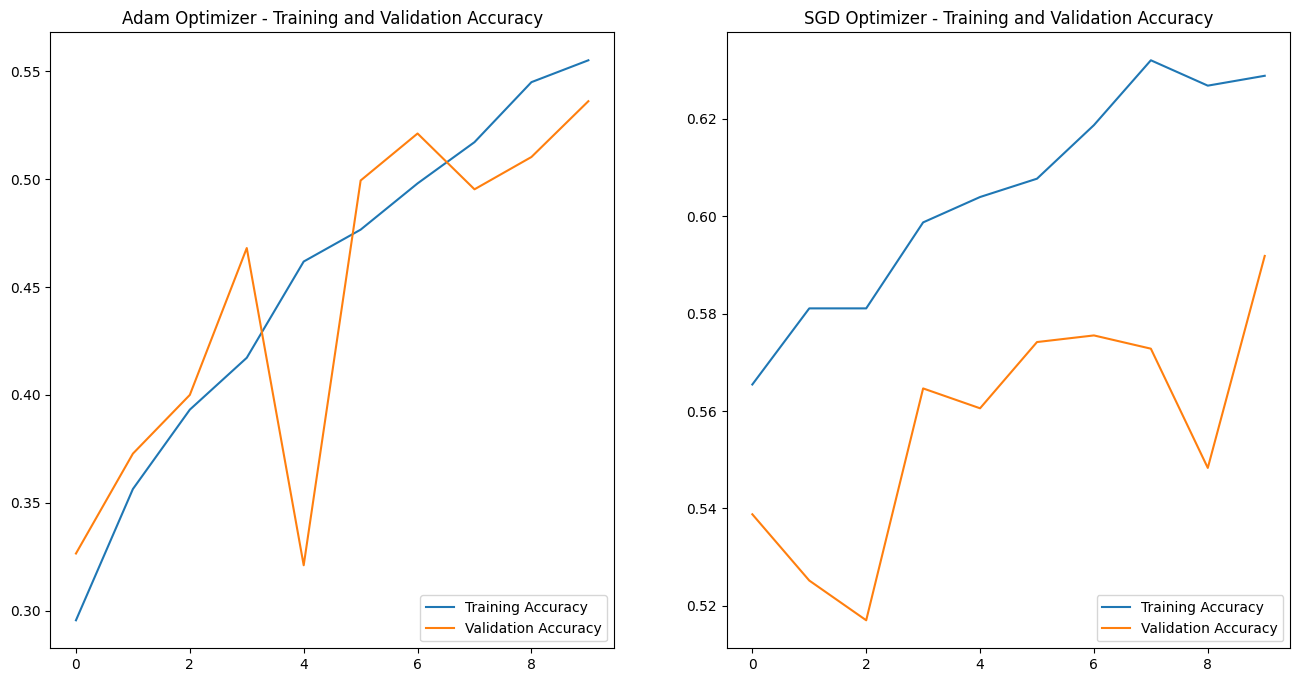

In [50]:
import matplotlib.pyplot as plt

def plot_training_dual(history1, history2, title1='Model 1', title2='Model 2'):
    acc1 = history1.history['accuracy']
    val_acc1 = history1.history['val_accuracy']
    loss1 = history1.history['loss']
    val_loss1 = history1.history['val_loss']

    acc2 = history2.history['accuracy']
    val_acc2 = history2.history['val_accuracy']
    loss2 = history2.history['loss']
    val_loss2 = history2.history['val_loss']

    epochs_range = range(len(acc1))

    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc1, label='Training Accuracy')
    plt.plot(epochs_range, val_acc1, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title1} - Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, acc2, label='Training Accuracy')
    plt.plot(epochs_range, val_acc2, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title2} - Training and Validation Accuracy')

    plt.show()

plot_training_dual(history_adam, history_sgd, title1='Adam Optimizer', title2='SGD Optimizer')

After 10 epochs, the results are looking good for both Adam and SGD. SGD shows some signs of overfitting, but before we throw in some regularization techniques, let's train for another 10 epochs on both models.

In [52]:
history_adam_additional = train(base_model_adam, epochs=10)
history_sgd_additional = train(base_model_sgd, epochs=10)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10
27/27 [==============================] - 64s 2s/step - loss: 0.9218 - accuracy: 0.6534 - val_loss: 1.0968 - val_accuracy: 0.5701
Epoch 2/10
27/27 [==============================] - 68s 3s/step - loss: 0.9046 - accuracy: 0.6514 - val_loss: 1.0614 - val_accuracy: 0.5973
Epoch 3/10
27/27 [==============================] - 64s 2s/step - loss: 0.8964 - accuracy: 0.6587 - val_loss: 1.0478 - val_accuracy: 0.5918
Epoch 4/10
27/27 [==============================] - 59s 2s/step - loss: 0.8945 - accuracy: 0.6529 - val_loss: 1.0882 - val_accuracy: 0.5796
Epoch 5/10
27/27 [==============================] - 61s 2s/step - loss: 0.8612 - accuracy: 0.6714 - val_loss: 1.0425 - val_accuracy: 0.6027
Epoch 6/10
27/27 [==============================] - 61s 2s/step - loss: 0.8435 - accuracy: 0.6807 - val_loss: 1.0659 - val_accuracy: 0.6122
Epoch 7/10
27/27 [==============================] - 61s 2s/step - loss: 0.8657 - accuracy: 0.6673 - val_loss: 1.1209 - val_accuracy: 0.5388
Epoch 8/10
27/27 [==

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10
27/27 [==============================] - 62s 2s/step - loss: 0.7909 - accuracy: 0.7009 - val_loss: 1.0578 - val_accuracy: 0.5850
Epoch 2/10
27/27 [==============================] - 60s 2s/step - loss: 0.7773 - accuracy: 0.7038 - val_loss: 1.0371 - val_accuracy: 0.6027
Epoch 3/10
27/27 [==============================] - 62s 2s/step - loss: 0.7647 - accuracy: 0.7128 - val_loss: 1.1021 - val_accuracy: 0.5878
Epoch 4/10
27/27 [==============================] - 60s 2s/step - loss: 0.7354 - accuracy: 0.7232 - val_loss: 1.0950 - val_accuracy: 0.5782
Epoch 5/10
27/27 [==============================] - 61s 2s/step - loss: 0.7316 - accuracy: 0.7171 - val_loss: 1.0655 - val_accuracy: 0.5796
Epoch 6/10
27/27 [==============================] - 64s 2s/step - loss: 0.7196 - accuracy: 0.7368 - val_loss: 1.1824 - val_accuracy: 0.5660
Epoch 7/10
27/27 [==============================] - 62s 2s/step - loss: 0.6905 - accuracy: 0.7487 - val_loss: 1.0749 - val_accuracy: 0.6177
Epoch 8/10
27/27 [==

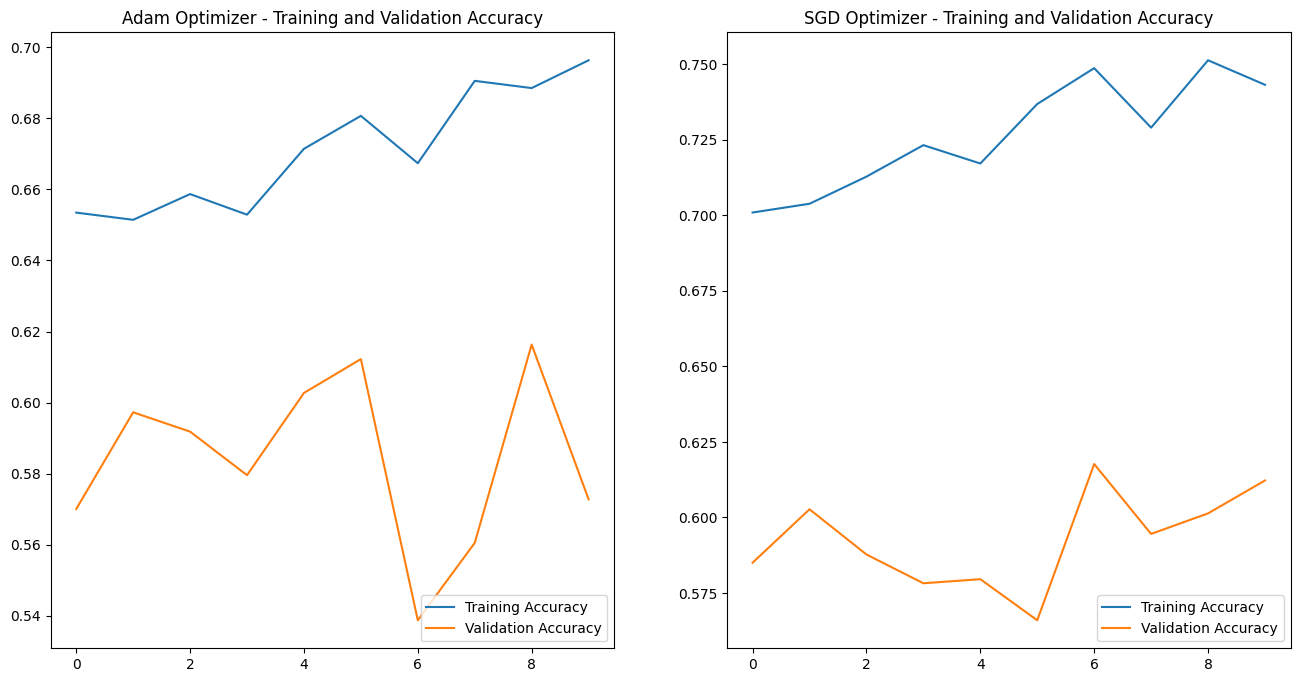

In [54]:
plot_training_dual(history_adam_additional, history_sgd_additional, title1='Adam Optimizer', title2='SGD Optimizer')

We see some improvements in Training Accuracy, however the Validation Acc struggles. We should try to implement some regularizations.